In [1]:
import os
print(os.getcwd())
import numpy as np

c:\Users\saidm\Documents\Universidad\9no_Semestre\Data Mining\Deberes\Deep-Learning


In [2]:
import pandas as pd
dfpath="hmnist_28_28_RGB.csv"
df=pd.read_csv(dfpath)
df.tail()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0
10014,175,142,121,181,150,134,181,150,133,178,...,159,79,82,174,137,125,175,139,126,6


In [3]:
# Extracting 'y' column
y = df['label']

# Extracting 'X' DataFrame without the 'label' column
X = df.drop(columns=['label'])
X_resize=np.array([i.reshape(28,28,3) for i in np.array(X)  ])
X_resize.shape

(10015, 28, 28, 3)

In [117]:
#%pip install tensorflow
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, auc, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, roc_curve, auc, precision_recall_curve,roc_curve, roc_auc_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization,ReLU,Add,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model
#from tensorflow_model_optimization.sparsity import keras as sparsity

# Define your CNN model


In [123]:
#from tensorflow_model_optimization.sparsity import keras as sparsity

# Define your CNN model
def create_model():
    model_cnn = Sequential([
        Conv2D(filters=32, kernel_size=(3,3), input_shape=(28, 28, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2,2), strides=2),
        Flatten(),
        Dense(units=7, activation='softmax')
    ])
    return model_cnn

def create_model_2():
    model_cnn = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
        MaxPool2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPool2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(7, activation='softmax')
    ])

    return model_cnn
def create_resnet_model():
    
    def residual_block(x, filters, kernel_size=3, strides=2):
        # First convolutional layer
        y = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
        y = BatchNormalization()(y)
        y = ReLU()(y)

        # Second convolutional layer
        y = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
        y = BatchNormalization()(y)

        # Shortcut connection
        if strides != 1:
            x = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
            x = BatchNormalization()(x)

        # Add the shortcut and residual
        y = Add()([x, y])
        y = ReLU()(y)
        return y
    inputs = Input(shape=(28, 28, 3))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPool2D((2, 2))(x)

    # First residual block
    x = residual_block(x, 64, strides=4)
    # Second residual block
    x = residual_block(x, 64)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(7, activation='softmax')(x)

    model_resnet = Model(inputs=inputs, outputs=outputs)
    
    return model_resnet

# Define function to train and evaluate model
def train_evaluate_model(X_train, y_train, X_test, y_test,num_model):

    model = create_resnet_model()
    checkpoint_path = f"model_{num_model}_checkpoint/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, verbose=1)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.save(checkpoint_dir+'/model.h5')
    history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks=[cp_callback])
    #model=load_model(checkpoint_dir+'/model.h5')
    eval_metrics = model.evaluate(X_test, y_test)
    
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    auc_score= roc_auc_score(y_test, y_pred, multi_class='ovr')
    acc = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred_classes)
    loss = eval_metrics[0]
    cm = confusion_matrix(y_test, y_pred_classes)

    return acc, auc_score, precision, recall, f1, mcc, loss, cm, y_pred,history



# Define function to plot AUC-ROC and Precision-Recall curves
def plot_curves_binary(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob[:, 1])

    plt.figure(figsize=(10, 5))

    # Plot AUC-ROC curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Plot Precision-Recall curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()


In [103]:

# Define function to plot AUC-ROC and Precision-Recall curves for multiclass
from itertools import cycle
from sklearn.calibration import label_binarize
def plot_curves(y_true, y_pred_prob, n_classes):
        # Binarize the output
        y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5, 6])

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute Precision-Recall curve for each class
        precision = dict()
        recall = dict()
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])

        plt.figure(figsize=(10, 5))

        # Plot ROC curve for each class
        plt.subplot(1, 2, 1)
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'yellow'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")

        # Plot Precision-Recall curve for each class
        plt.subplot(1, 2, 2)
        for i, color in zip(range(n_classes), colors):
            plt.plot(recall[i], precision[i], color=color, lw=2, label='Precision-Recall curve of class {0}'.format(i))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")

        plt.tight_layout()
        plt.show()

In [104]:
# another function. First we calculate the roc_auc_score for each class and then we calculate the mean of all the scores. and then we plot the roc curve
# we do the same for the precision-recall curve
def plot_curves_v2(y_true, y_pred_prob, n_classes):
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5, 6])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute Precision-Recall curve for each class
    precision = dict()
    recall = dict()
    
    # Compute micro-average Precision-Recall curve and area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), y_pred_prob.ravel())

    plt.figure(figsize=(10, 5))

   #calculate the mean of the roc_auc_score
    all_auc = np.mean(list(roc_auc.values()))
    # Plot all_auc score
    plt.subplot(1, 2, 1)
    plt.plot(fpr["micro"], tpr["micro"], color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % all_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic mean AUC')
    plt.legend(loc="lower right")
    
    # Plot all_precision-recall score
    plt.subplot(1, 2, 2)
    plt.plot(recall["micro"], precision["micro"], color='green', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve mean Precision and Recall')
    plt.legend(loc="lower left")
    


In [124]:
# Define lists to store evaluation metrics
acc_scores = []
auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
mcc_scores = []
loss_scores = []
cm_list = []
y_pred_list = []
history_list=[]
n_splits=5
# Define Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
print("training model")
i=0
for train_index, test_index in skf.split(X_resize, y):
    
    X_train, X_test = X_resize[train_index], X_resize[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    acc, auc_score, precision, recall, f1, mcc, loss, cm, y_pred,history = train_evaluate_model(X_train, y_train, X_test, y_test,i)
    
    acc_scores.append(acc)
    auc_scores.append(auc_score)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    mcc_scores.append(mcc)
    loss_scores.append(loss)
    cm_list.append(cm)
    y_pred_list.append(y_pred)
    history_list.append(history)
    print(f"model{i} trained")
    i+=1

# Calculate mean and standard deviation for each metric
mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)

mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)

mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

mean_mcc = np.mean(mcc_scores)
std_mcc = np.std(mcc_scores)

mean_loss = np.mean(loss_scores)
std_loss = np.std(loss_scores)



training model
Epoch 1/200


c:\Users\saidm\AppData\Local\pypoetry\Cache\virtualenvs\cybersecurity-Z7yOgMbu-py3.11\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


251/251 [==============================] - ETA: 0s - loss: 0.9380 - accuracy: 1.2481e-04
Epoch 1: val_loss improved from inf to 0.88355, saving model to model_0_checkpoint\cp.ckpt
251/251 [==============================] - 5s 10ms/step - loss: 0.9380 - accuracy: 1.2481e-04 - val_loss: 0.8836 - val_accuracy: 0.0000e+00
Epoch 2/200
244/251 [============================>.] - ETA: 0s - loss: 0.8048 - accuracy: 0.0023
Epoch 2: val_loss improved from 0.88355 to 0.80779, saving model to model_0_checkpoint\cp.ckpt
251/251 [==============================] - 2s 10ms/step - loss: 0.8049 - accuracy: 0.0025 - val_loss: 0.8078 - val_accuracy: 0.0130
Epoch 3/200
245/251 [============================>.] - ETA: 0s - loss: 0.7394 - accuracy: 0.0106
Epoch 3: val_loss improved from 0.80779 to 0.77494, saving model to model_0_checkpoint\cp.ckpt
251/251 [==============================] - 2s 9ms/step - loss: 0.7403 - accuracy: 0.0104 - val_loss: 0.7749 - val_accuracy: 0.0070
Epoch 4/200
243/251 [============

c:\Users\saidm\AppData\Local\pypoetry\Cache\virtualenvs\cybersecurity-Z7yOgMbu-py3.11\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


248/251 [============================>.] - ETA: 0s - loss: 0.9400 - accuracy: 8.8206e-04
Epoch 1: val_loss improved from inf to 0.88997, saving model to model_1_checkpoint\cp.ckpt
251/251 [==============================] - 6s 13ms/step - loss: 0.9422 - accuracy: 8.7369e-04 - val_loss: 0.8900 - val_accuracy: 4.9925e-04
Epoch 2/200
250/251 [============================>.] - ETA: 0s - loss: 0.7901 - accuracy: 0.0080
Epoch 2: val_loss improved from 0.88997 to 0.80490, saving model to model_1_checkpoint\cp.ckpt
251/251 [==============================] - 3s 11ms/step - loss: 0.7905 - accuracy: 0.0081 - val_loss: 0.8049 - val_accuracy: 0.0050
Epoch 3/200
249/251 [============================>.] - ETA: 0s - loss: 0.7231 - accuracy: 0.0154
Epoch 3: val_loss did not improve from 0.80490
251/251 [==============================] - 3s 11ms/step - loss: 0.7267 - accuracy: 0.0154 - val_loss: 0.8257 - val_accuracy: 0.0035
Epoch 4/200
248/251 [============================>.] - ETA: 0s - loss: 0.6812 - 

In [106]:
results_per_model = pd.DataFrame({
    "Model": [f"Model {i}" for i in range(n_splits)],
    "Accuracy": acc_scores,
    "AUC": auc_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores,
    "MCC": mcc_scores,
    "Loss": loss_scores
})
print("Performance Metrics per Model:")
print(results_per_model)

# Display results in a table
results_df = pd.DataFrame({
    "Metric": ["Accuracy", "AUC", "Precision", "Recall", "F1 Score", "MCC", "Loss"],
    "Mean": [mean_acc, mean_auc, mean_precision, mean_recall, mean_f1, mean_mcc, mean_loss],
    "Std Dev": [std_acc, std_auc, std_precision, std_recall, std_f1, std_mcc, std_loss]
})

print("Performance Metrics of all models:")
print(results_df)



Performance Metrics per Model:
     Model  Accuracy       AUC  Precision    Recall  F1 Score       MCC  \
0  Model 0  0.756487  0.922639   0.730559  0.756487  0.738082  0.494165   
1  Model 1  0.761477  0.914267   0.750492  0.761477  0.748878  0.522734   
2  Model 2  0.746507  0.906768   0.738732  0.746507  0.736864  0.501609   
3  Model 3  0.758483  0.922617   0.749925  0.758483  0.750993  0.528986   
4  Model 4  0.746507  0.915904   0.735534  0.746507  0.734651  0.493792   
5  Model 5  0.747253  0.921251   0.726849  0.747253  0.725479  0.476019   
6  Model 6  0.734266  0.921536   0.727403  0.734266  0.724669  0.483327   
7  Model 7  0.756244  0.928403   0.732376  0.756244  0.719590  0.472990   
8  Model 8  0.776224  0.926939   0.749589  0.776224  0.754771  0.533749   
9  Model 9  0.749251  0.923819   0.723672  0.749251  0.713550  0.464775   

       Loss  
0  0.671440  
1  0.669179  
2  0.698031  
3  0.668851  
4  0.687388  
5  0.665124  
6  0.681093  
7  0.675531  
8  0.636474  
9  

Best Model : 7

Confusion Matrix of the Best Model (Maximized AUC):
[[ 13   9   1   0   8   0   1]
 [  6  20   5   0  18   1   2]
 [  3   3  39   0  61   0   4]
 [  1   4   2   1   4   0   0]
 [  1   2  11   0 653   0   3]
 [  0   1   0   0   8   5   0]
 [  1   2  18   1  63   0  26]]
Lengths of y_test and best_y_pred are equal.


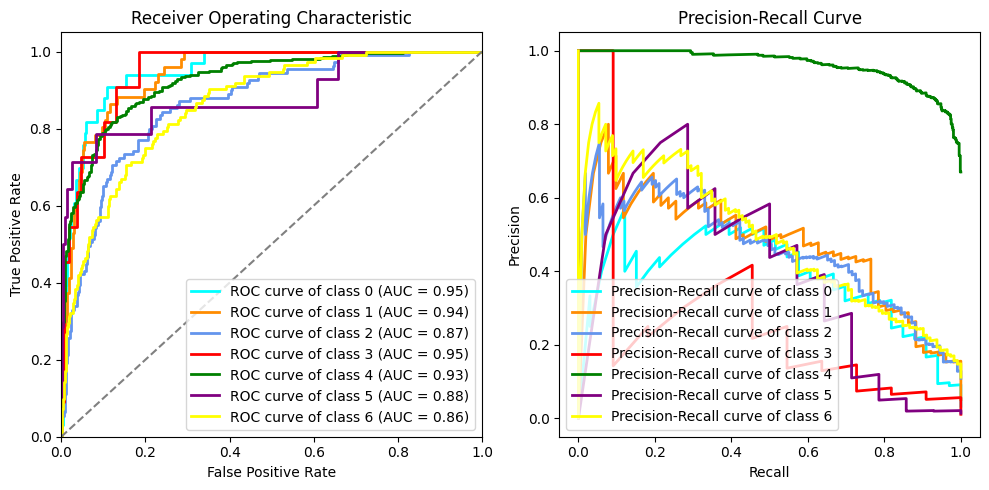

In [107]:
# Display confusion matrix of the best model
best_auc_index = np.argmax(auc_scores)
print("Best Model : " + str(best_auc_index))
best_cm = cm_list[best_auc_index]
print("\nConfusion Matrix of the Best Model (Maximized AUC):")
print(best_cm)

#Best prediction
best_y_pred = y_pred_list[best_auc_index]

# Ensure that y_test and best_y_pred have the same length
if len(y_test) > len(best_y_pred):
    y_test = y_test[:len(best_y_pred)]
    print("Lengths of y_test and best_y_pred are not equal. Resized y_test to match the length of best_y_pred.")
elif len(best_y_pred) > len(y_test):
    best_y_pred = best_y_pred[:len(y_test)]
    print("Lengths of y_test and best_y_pred are not equal. Resized best_y_pred to match the length of y_test.")
elif len(y_test) == len(best_y_pred):
    print("Lengths of y_test and best_y_pred are equal.")
# Now, you can plot the curves
plot_curves(y_test, best_y_pred, n_classes=7)

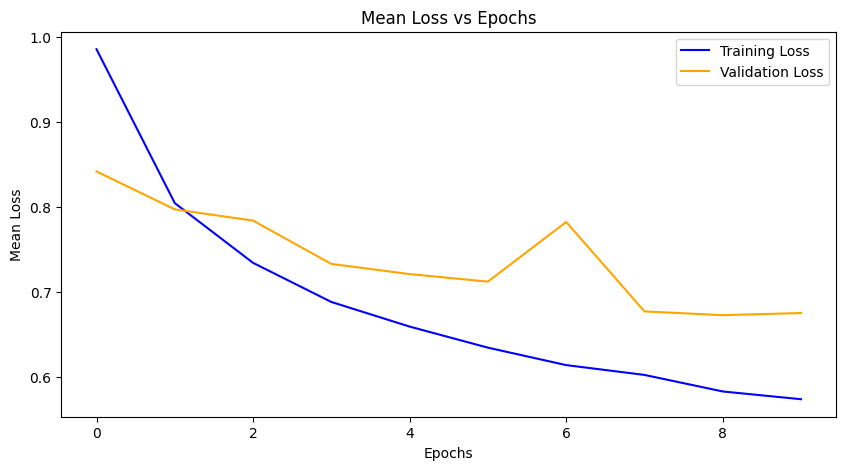

In [108]:

history=history_list[best_auc_index]
# Plot mean loss vs epochs for training and validation
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')
plt.title('Mean Loss vs Epochs')
plt.legend()

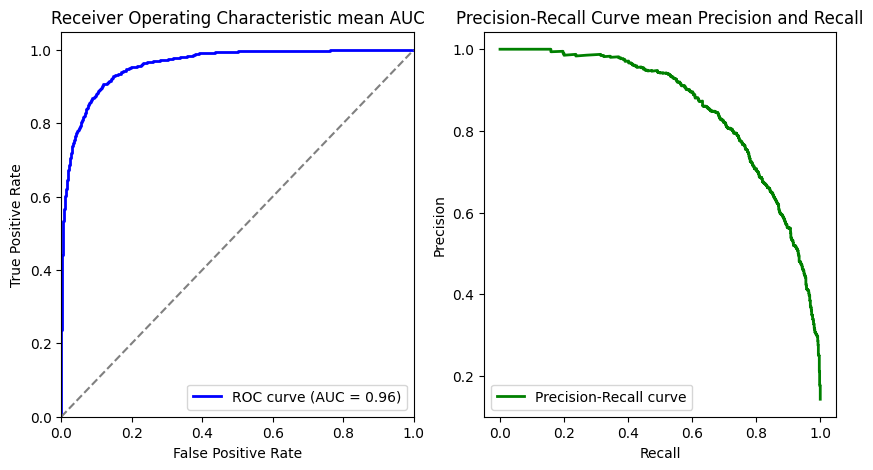

In [109]:
plot_curves_v2(y_test, best_y_pred, n_classes=7)